In [1]:
import pandas as pd
import pickle
from datasets import Dataset
from collections import Counter
from utils import id2label, label2id, classes
import matplotlib.pyplot as plt
import numpy as np
# import torch
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# from torch.nn.functional import softmax
# from transformers import AutoTokenizer, DataCollatorWithPadding
# from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from tqdm.notebook import tqdm as tqdm

from kleinberg import burst_detection, enumerate_bursts, burst_weights

In [2]:
colors = {'dialogues' : 'red', 
          'dissertation' : 'orange', 
          'enquiry' : 'yellow', 
          'essay': 'green', 
          'history' : 'grey',
          'political discourses' : 'blue', 
          'treatise' : 'purple'} 

rectangle_starts = {'dialogues' : (0.3, 0.4), 
          'dissertation' : (0.4, 0.5), 
          'enquiry' : (0.5, 0.6), 
          'essay': (0.6, 0.7), 
          'history' : (0.7, 0.8),
          'political discourses' : (0.8, 0.9), 
          'treatise' : (0.9, 1)} 

In [3]:
df = pd.read_json('all.json')
essay_dataset = df[df.genre=='essay']
titles = essay_dataset['title'].to_list()
DATA = Dataset.from_pandas(essay_dataset)

In [4]:
# id of paragraph where each chapter starts
titles_d = {}
for i in range(len(titles)):
    if titles[i] not in titles_d:
        titles_d[titles[i]] = {'start':i}
        
for i in range(len(titles)-1):
    titles_d[titles[i]]['end'] = titles_d[titles[i+1]]['start']
    
titles_d['Essay 2: Of Suicide']['end'] = len(essay_dataset)+1
        
# titles_inv = {val:key for key, val in titles_d.items()}

In [5]:
def predict_logreg(model_path='models/logreg.pkl', vect_path='models/tfidf_vectorizer.pkl'):

    # load
    with open(model_path, 'rb') as f:
        model = pickle.load(f)

    with open(vect_path, 'rb') as f:
        vect = pickle.load(f)

    x_test = vect.transform(DATA['text'])
    pred = model.predict_proba(x_test)
    
    return pred

In [6]:
pred_logreg = predict_logreg('models/logreg_stopwords.pkl', 'models/tfidf_vectorizer_stopwords.pkl')

In [7]:
def extract_bursts(essay, genre_id, pred):
    
    threshold = 0.15
    weight_threshold = 0.5
    
    
    # borders
    start = titles_d[essay]['start'] # starting paragraph
    end = titles_d[essay]['end'] # ending paragraph + 1
    
    target_events = [line[genre_id]*100 for line in pred[start:end]]
    
    events = [100 for i in range(len(target_events))]
    
    #number of target events at each time point
    r = np.array(target_events, dtype=float)
    
    if not sum(r): # no target events
        return [], []
    
    #total number of events at each time point
    d = np.array(events, dtype=float)
    #number of time points
    n = len(r)

    #find the optimal state sequence (q)
    q, d, r, p = burst_detection(r, d, n, s=2, gamma=0.01, smooth_win=1)

    #enumerate bursts based on the optimal state sequence
    bursts = enumerate_bursts(q, 'burstLabel')

    #find weight of bursts
    weighted_bursts = burst_weights(bursts, r, d, p)
    
    res = weighted_bursts[weighted_bursts['weight'] >= weight_threshold]
    
    lefts = res['begin'].to_list()
    rights = res['end'].to_list()
    
    return lefts, rights

In [8]:
def draw_genre(essay, genre, pred):
    
    genre_id = label2id[genre]
        
    lefts, rights = extract_bursts(essay, genre_id, pred)

    def draw_section(left, right, genre):

        def f(t):
            return 1

        section = np.arange(left, right+1, 1)
        plt.fill_between(section, 
                         y1 = rectangle_starts[genre][0],
                         y2 = rectangle_starts[genre][1],
                         alpha = 0.7, color=colors[genre])

    for l, r in zip(lefts, rights):
        draw_section(l, r, genre)

In [9]:
def draw_essay(essay, pred, draw_bursts=True):
    n = 7 # number of genres

    fig, ax = plt.subplots(figsize=(15, 5), layout='constrained')

    start = titles_d[essay]['start'] # starting paragraph
    end = titles_d[essay]['end'] # ending paragraph + 1

    x = np.array([i for i in range(len(pred[start:end]))]) # go through paragraphs
    for i in range(n):
        y = pred.T[i][start:end]
        y = [v if v > 0.05 else None for v in y]
        ax.scatter(x,y, label=id2label[i], color=colors[id2label[i]], alpha=0.6) # draw dots

    ax.legend()
    plt.title(essay)
        
    if draw_bursts:
        for genre in label2id.keys():
            draw_genre(essay, genre, pred)
        
    plt.show()

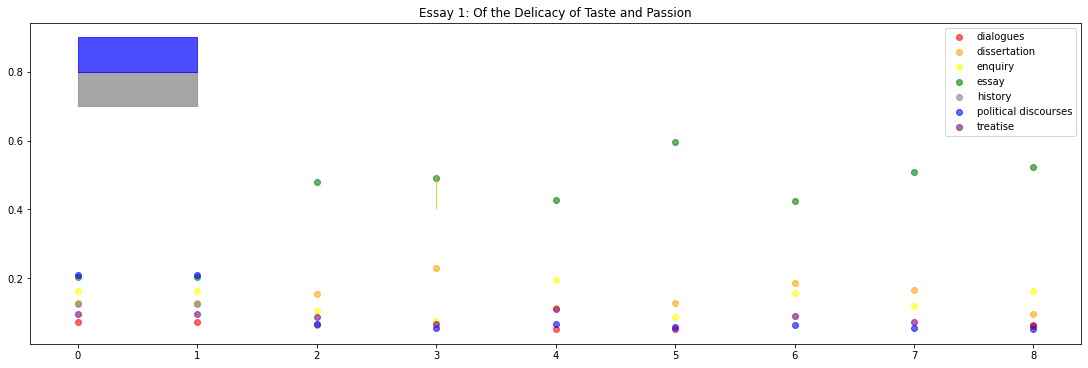

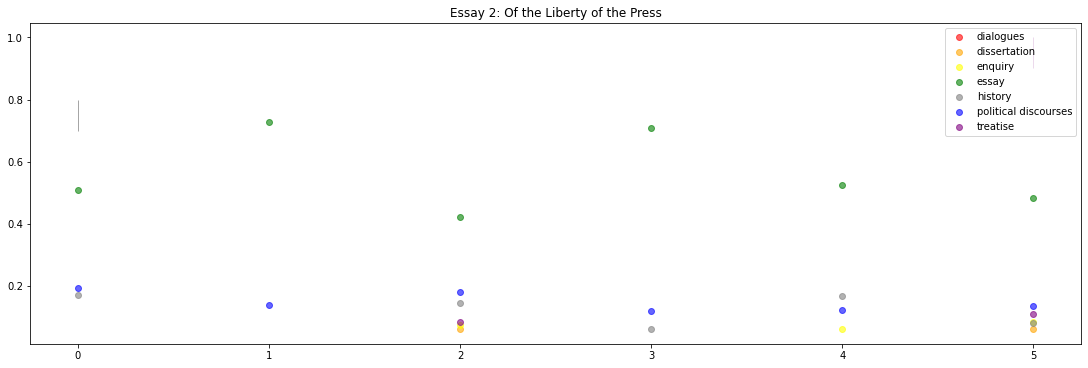

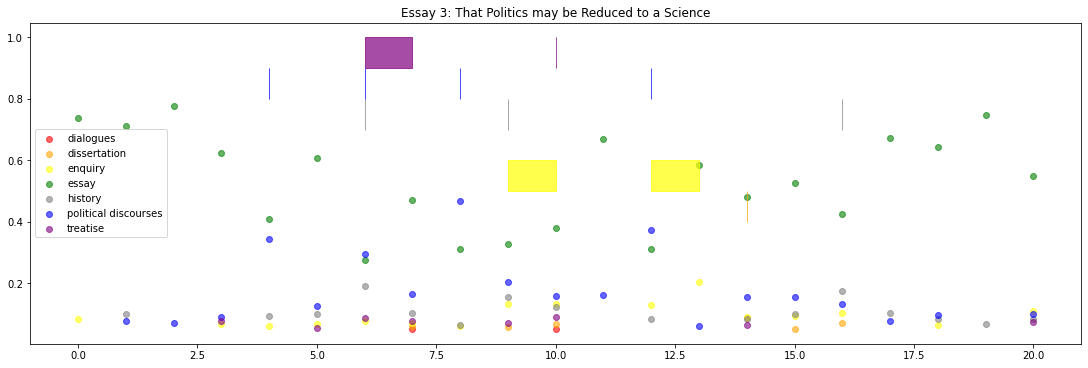

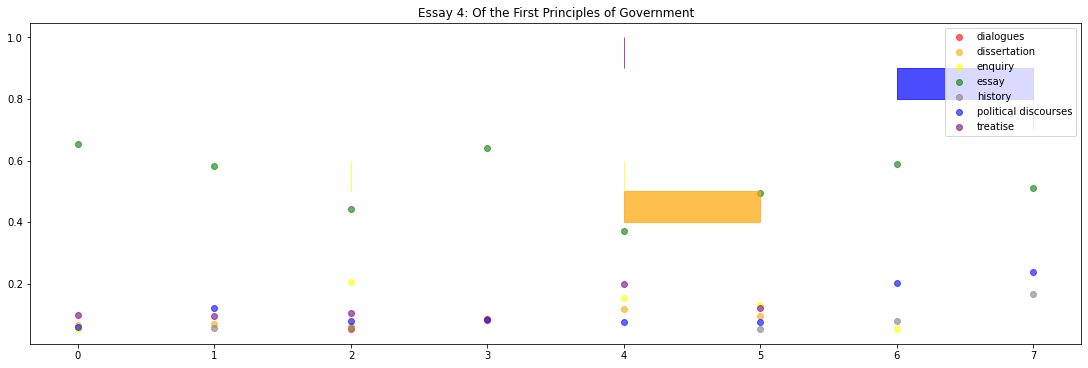

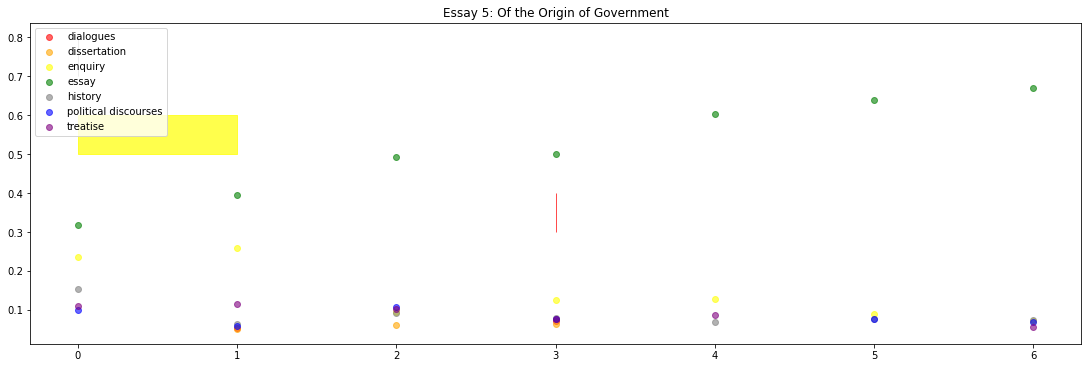

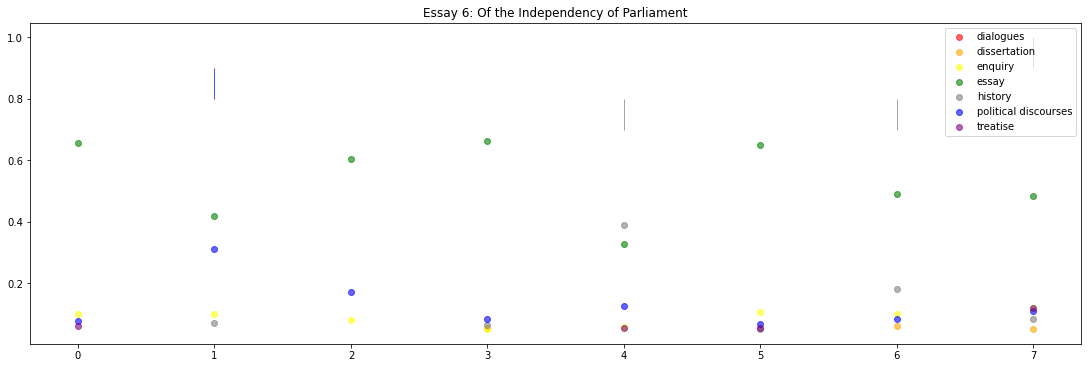

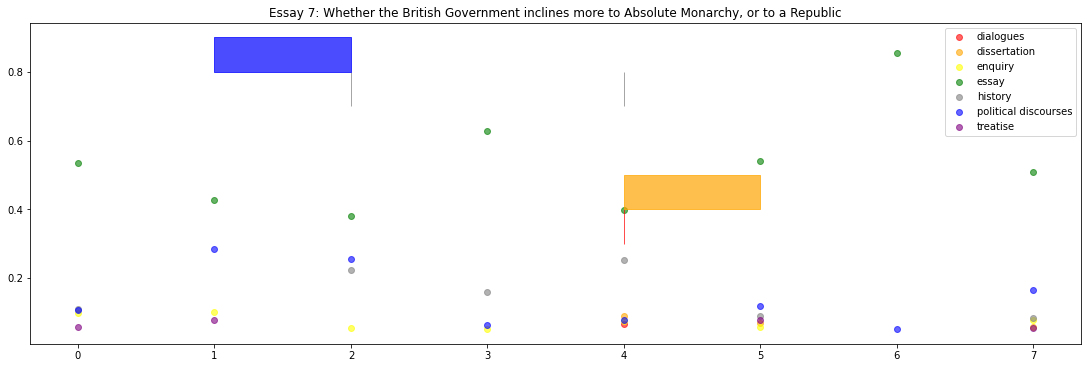

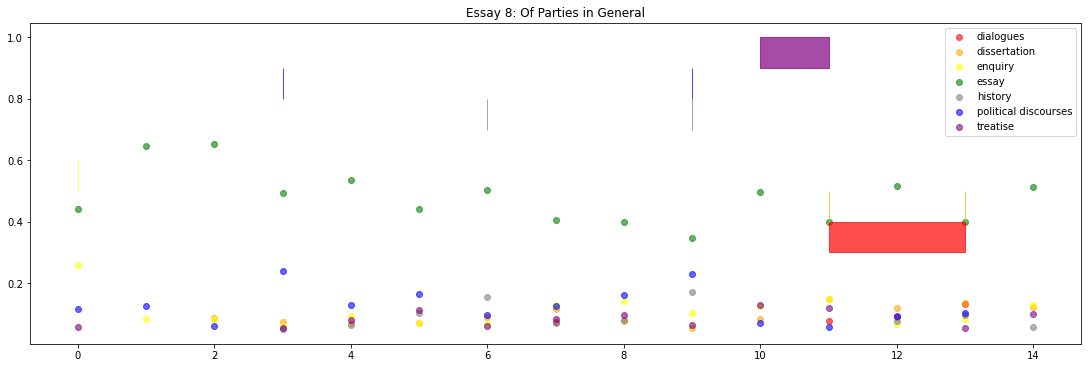

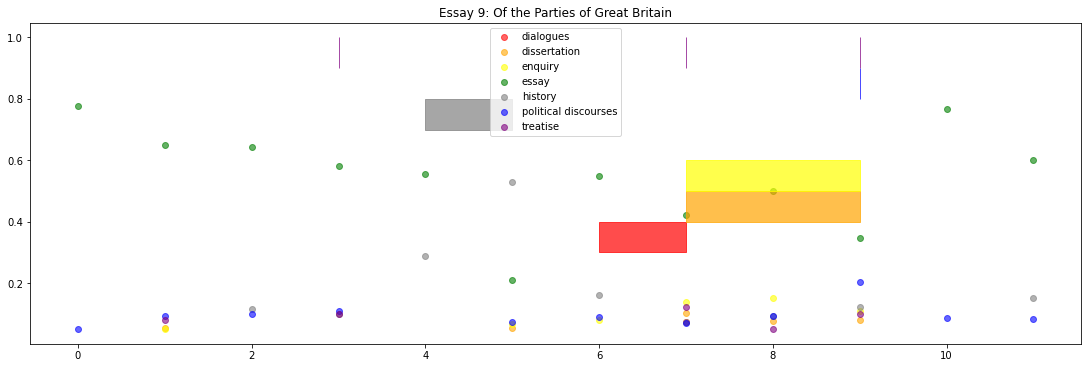

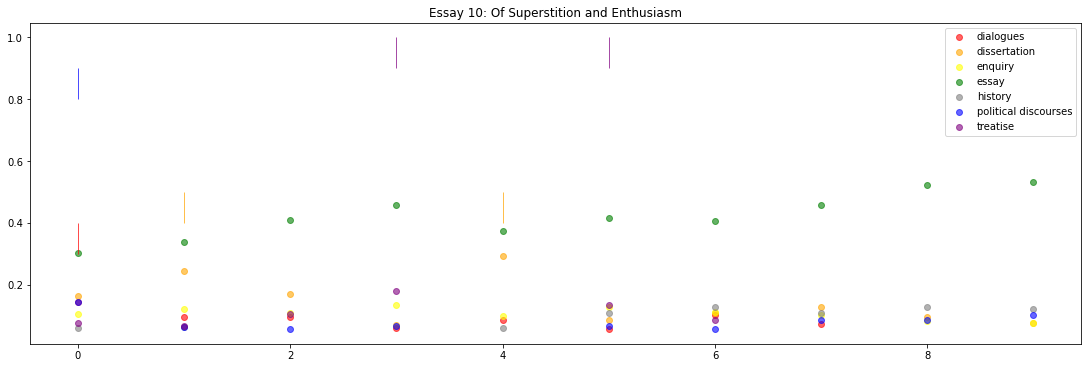

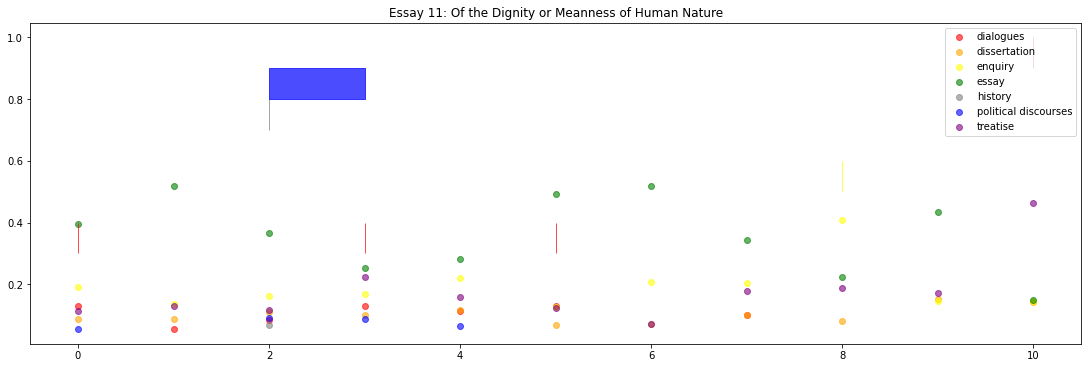

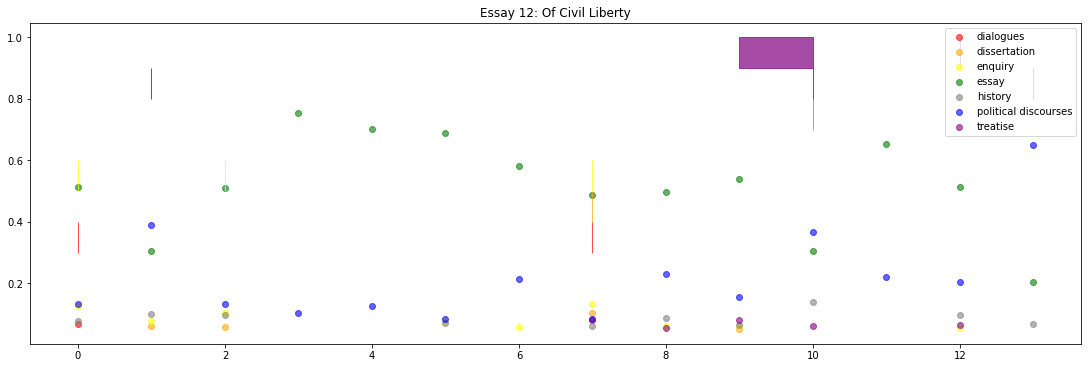

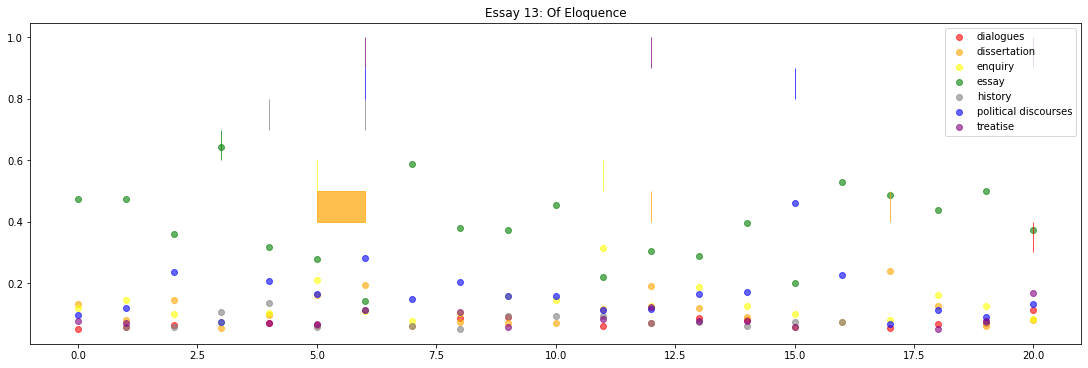

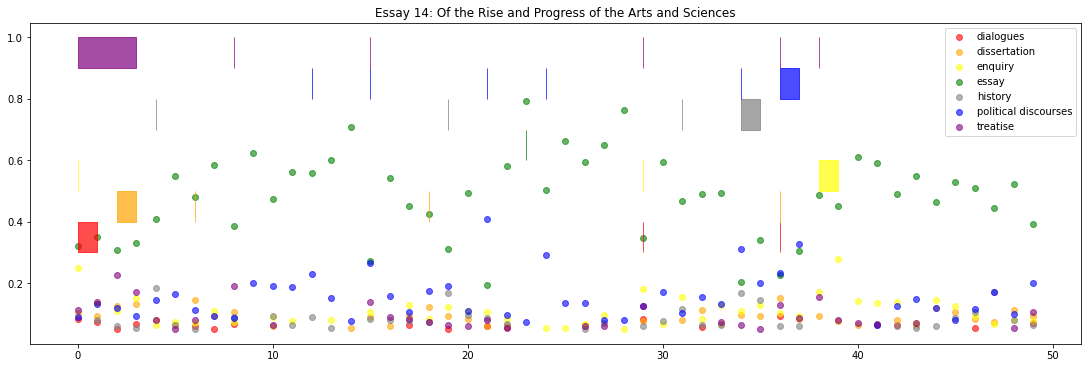

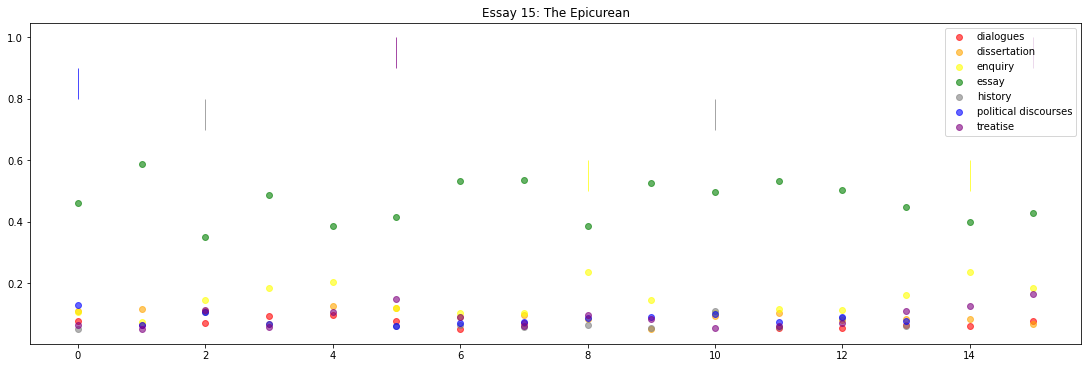

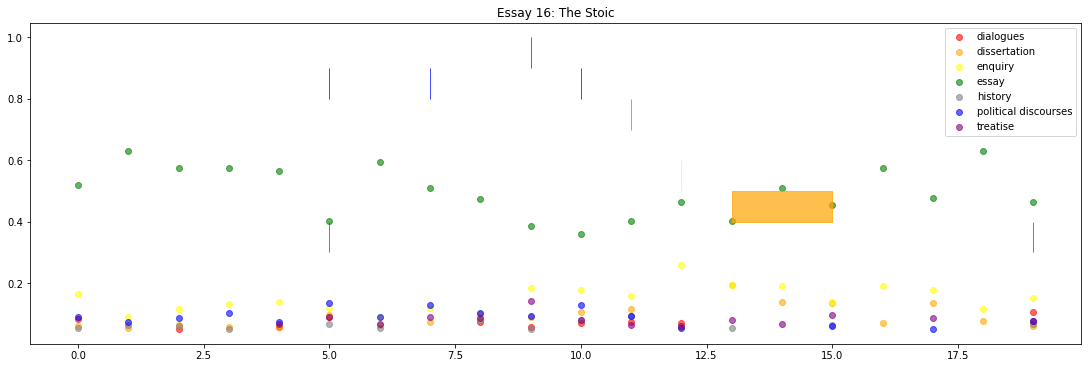

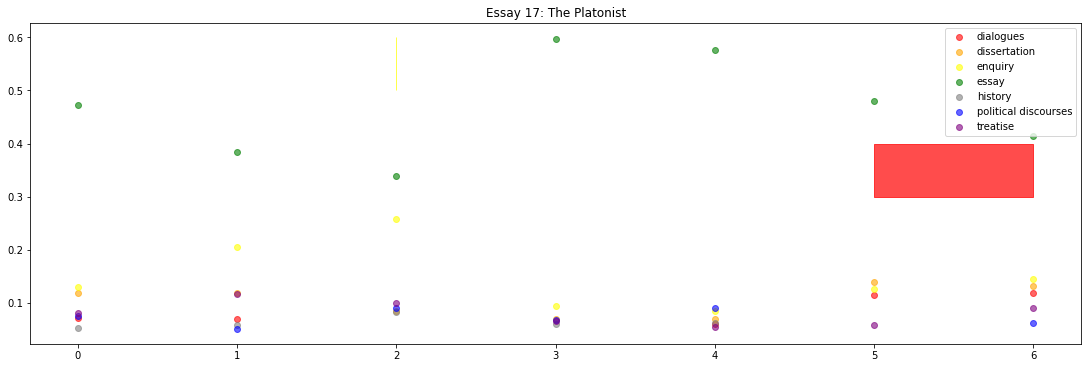

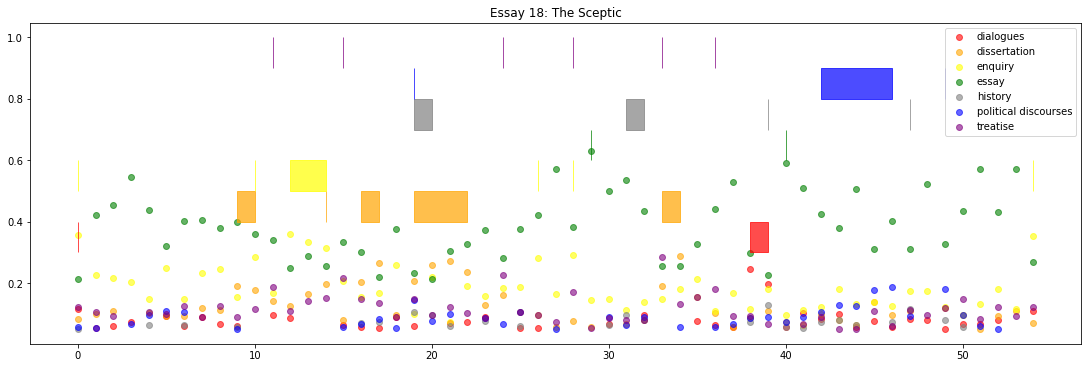

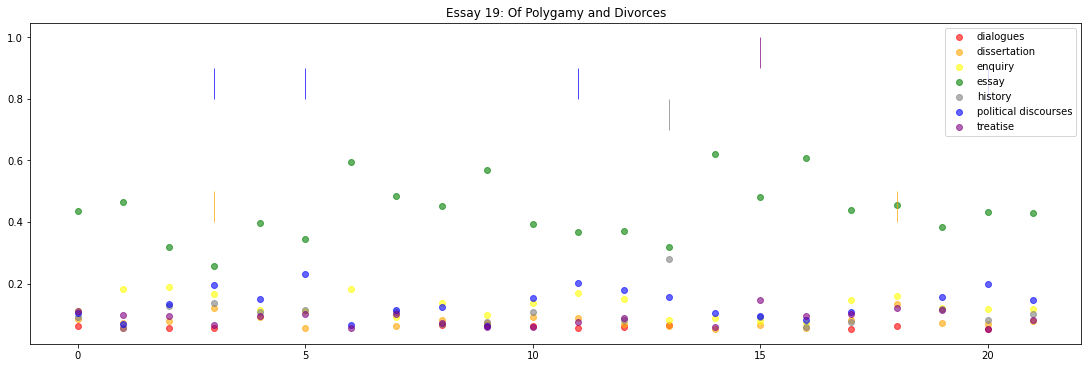

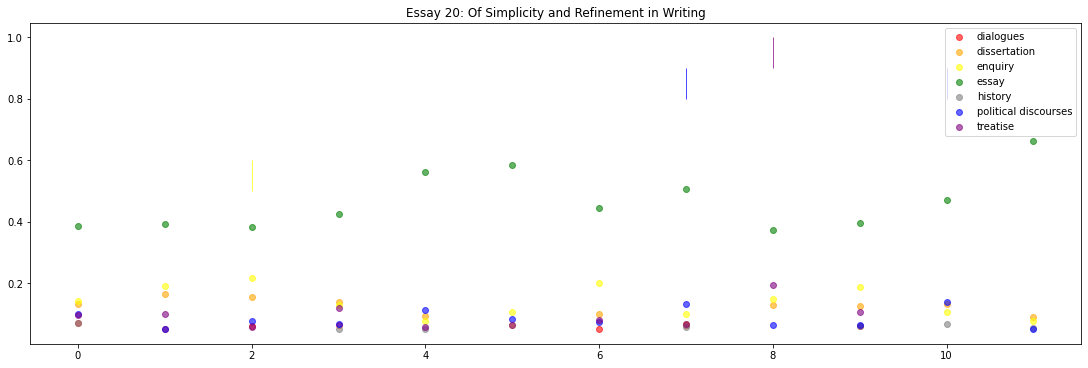

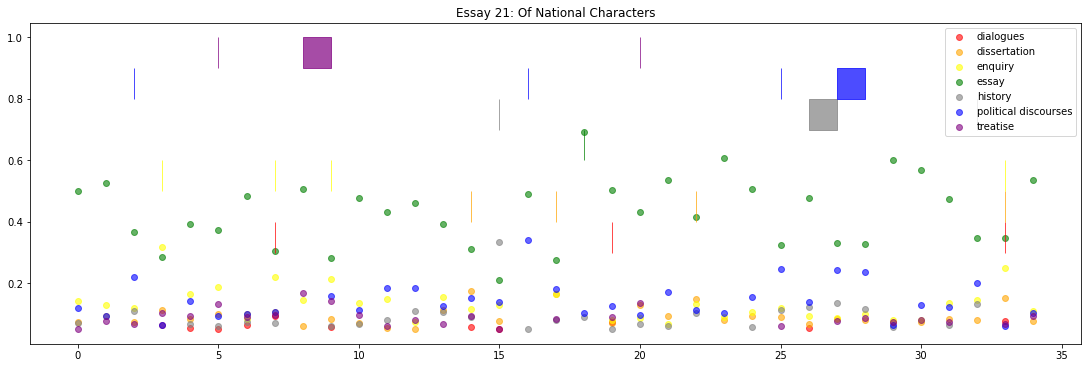

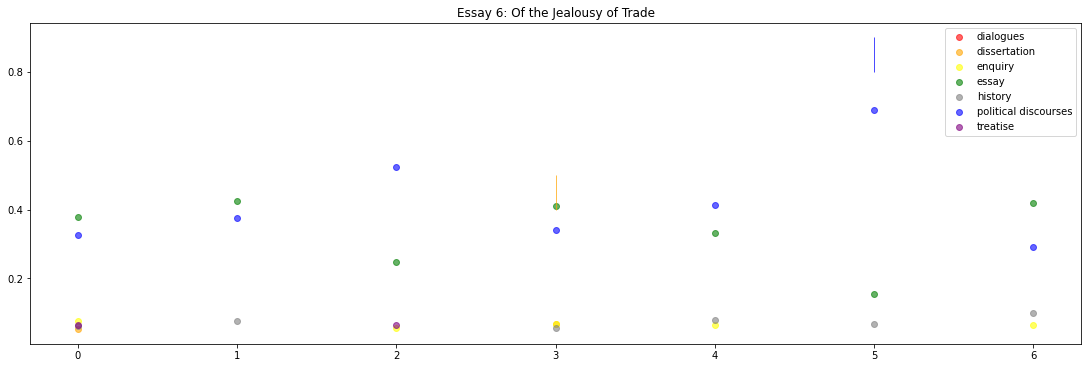

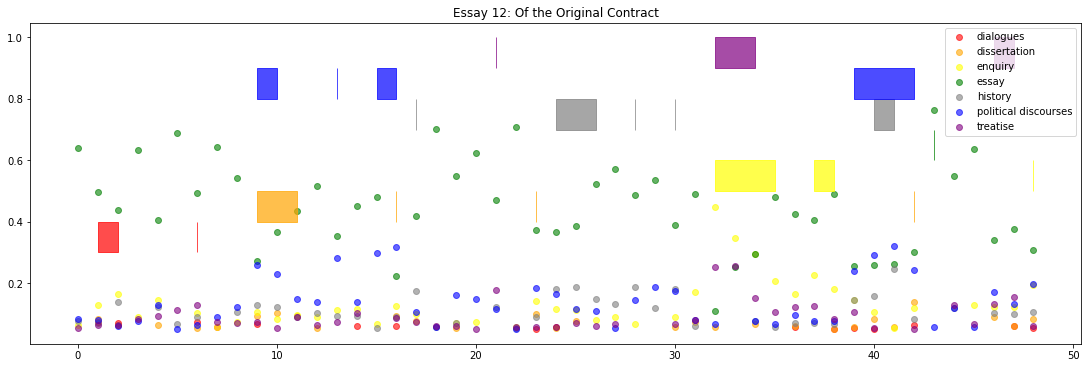

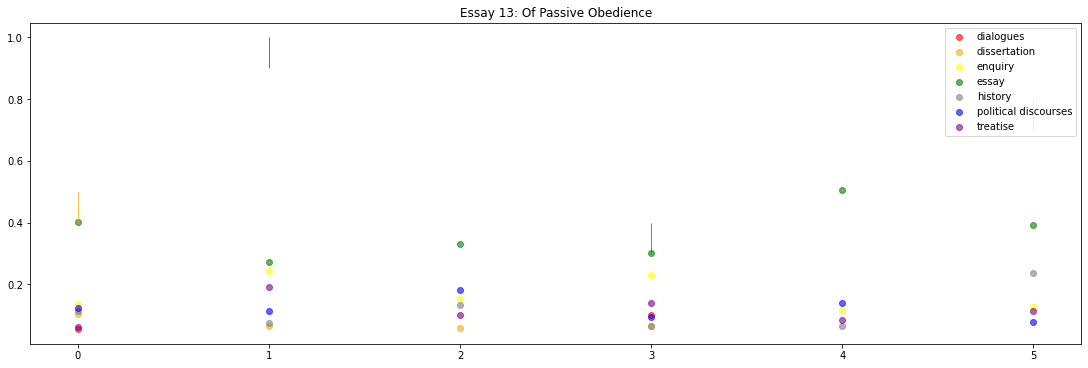

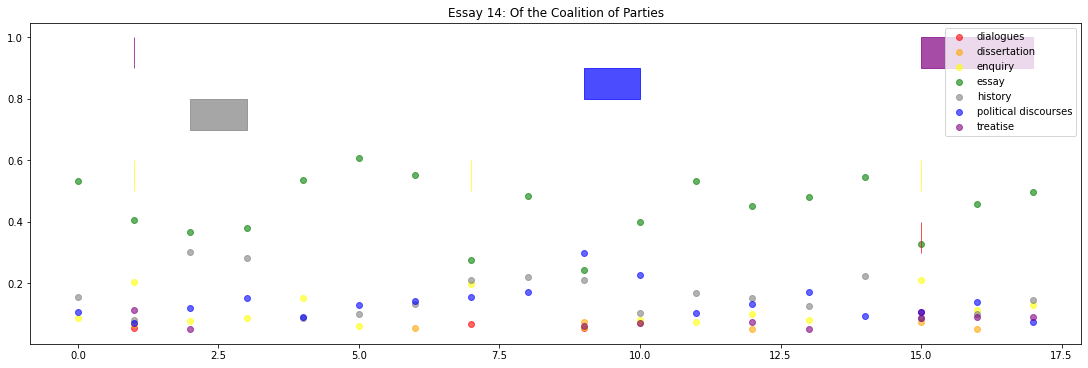

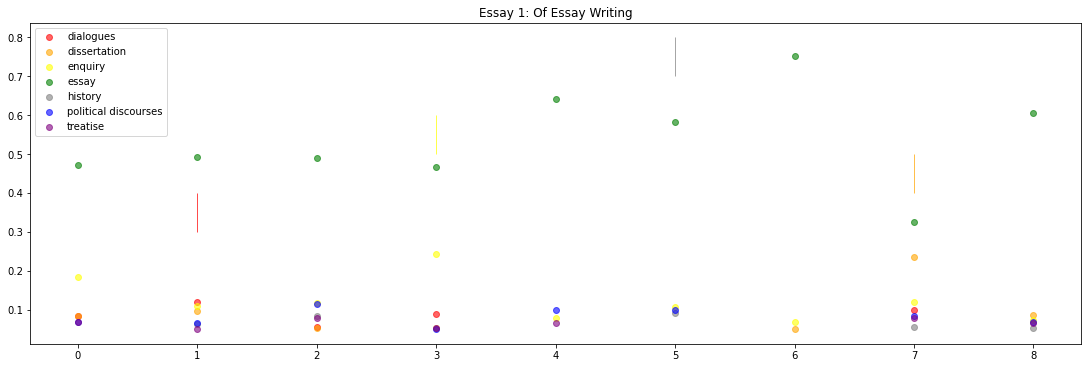

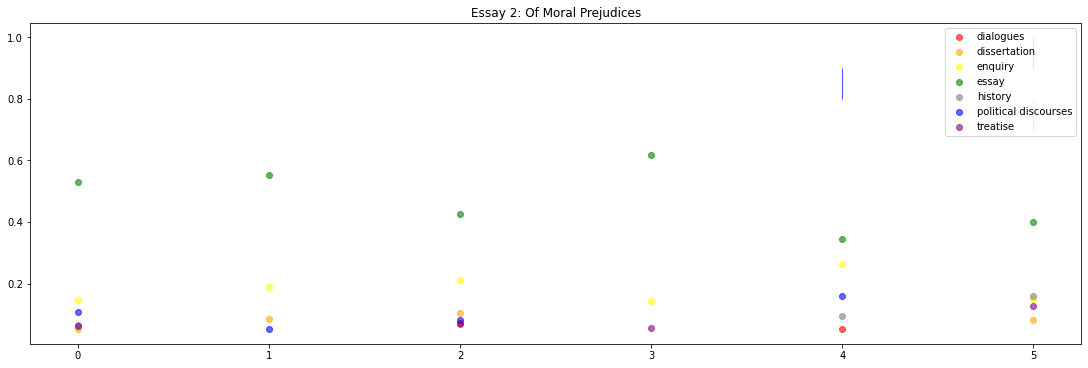

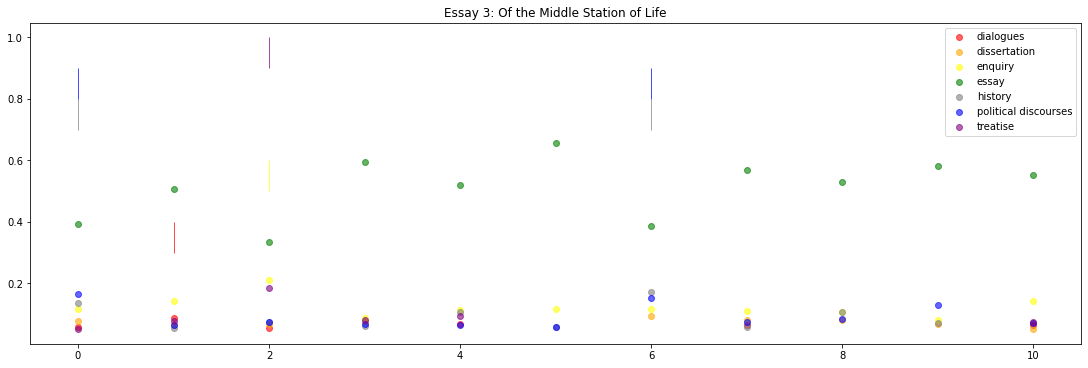

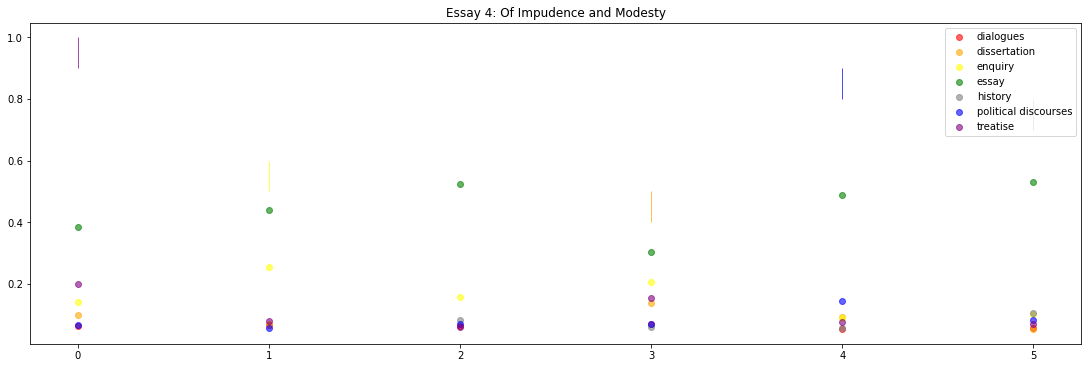

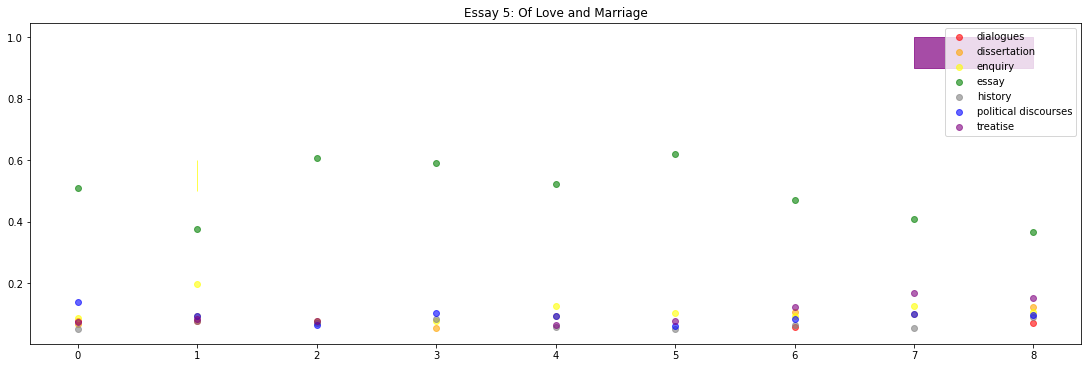

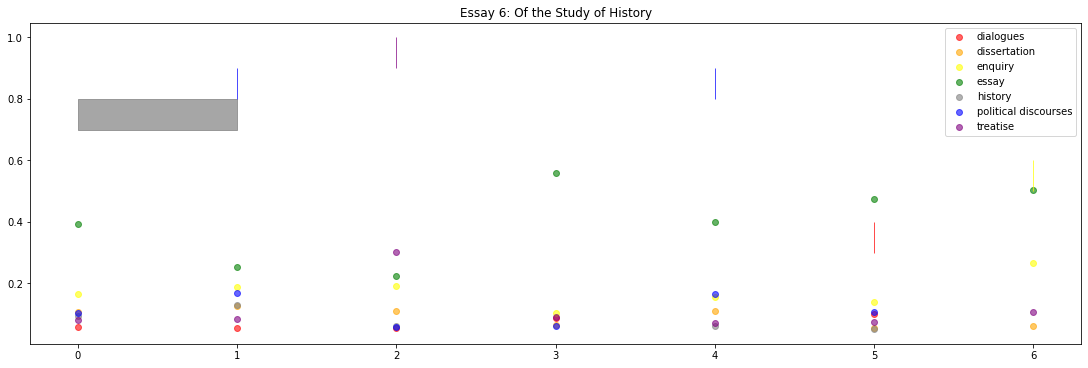

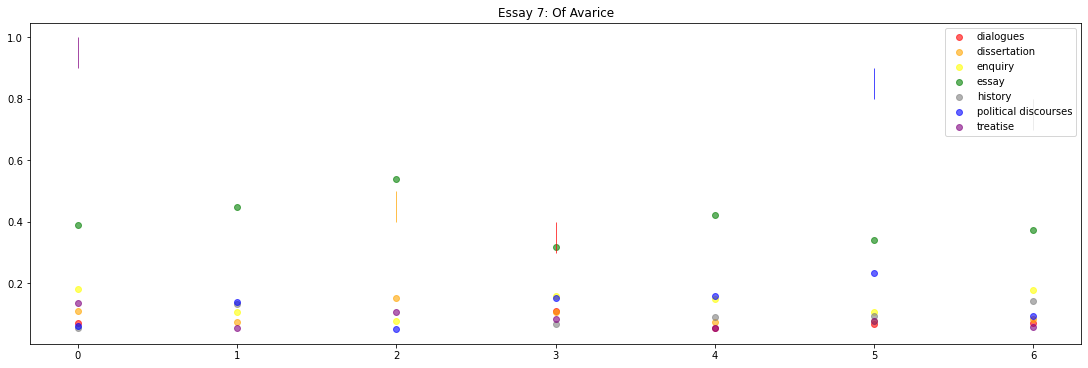

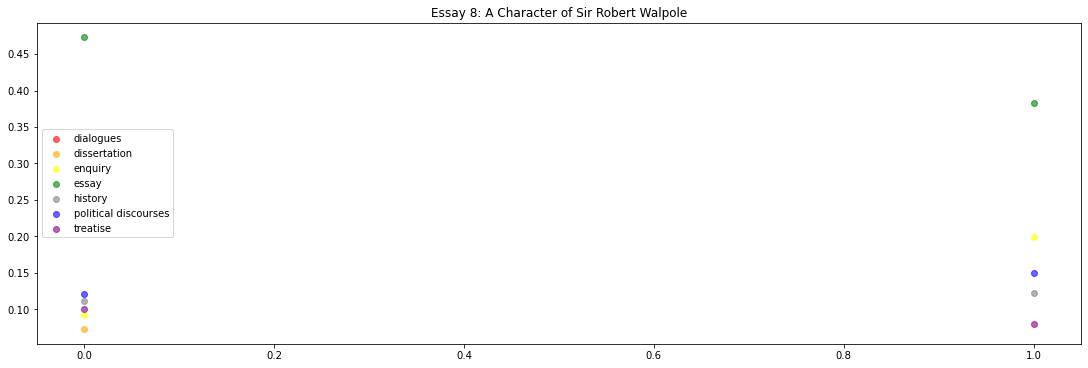

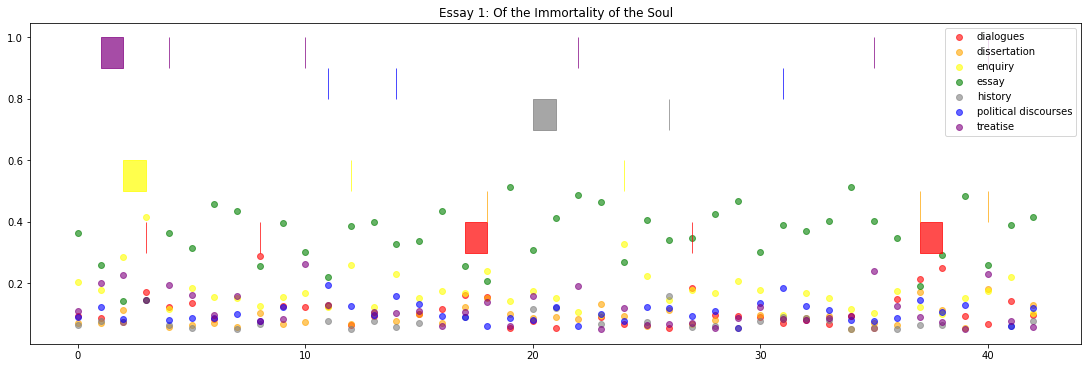

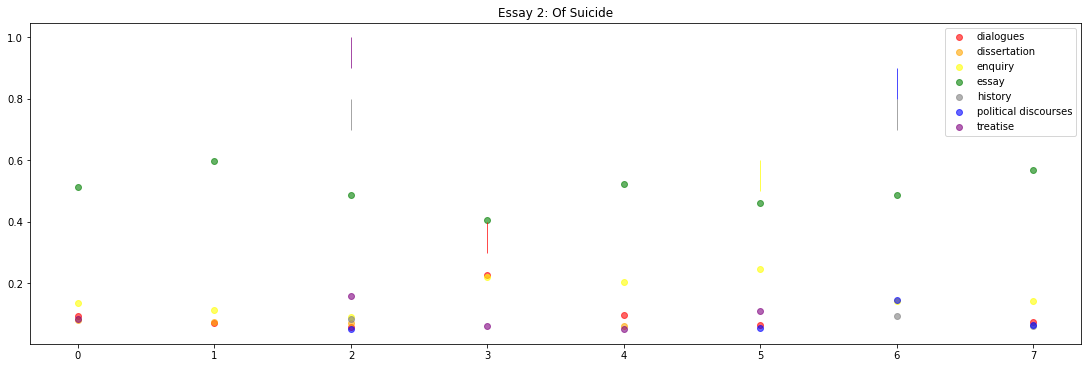

In [10]:
for essay in titles_d.keys():
    draw_essay(essay, pred_logreg, True)